In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import pandas as pd
import math
from math import floor,ceil
import utils
from utils import wrapToPi
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PFN_model import PFN, BuildSSInitial
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline

C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} =
f(\mathbf{x}) = \begin{bmatrix}
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} =
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [2]:
state_names = ['x',  # x position [m]
               'y',  # y position [m]
               'z',  # z position (altitude) [m]
               'v_para',  # parallel velocity [m/s]
               'v_perp',  # perpendicular velocity [m/s]
               'phi', # heading [rad]
               'phi_dot',  # angular velocity [rad/s]
               'w',  # ambient wind speed [m/s]
               'zeta',  # ambient wind angle [rad]
               'm', # mass [kg]
               'I',  # inertia [kg*m^2]
               'C_para',  # parallel damping [N*s/m]
               'C_perp',  # perpendicular damping [N*s/m]
               'C_phi',  # rotational damping [N·m/rad/s]
               'km1',  # parallel motor calibration coefficient
               'km2',  # offset motor calibration coefficient
               'km3',  # perpendicular motor calibration coefficient
               'km4',  # rotational motor calibration coefficient
               ]

input_names = ['u_para',  # parallel thrust force [N]
               'u_perp',  # perpendicular thrust force [N]
               'u_phi',  # torque [N*m]
               'u_w',  # wind speed control
               'u_zeta'  # wind direction control
               ]
def f(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X

    # Inputs
    u_para, u_perp, u_phi, u_w, u_zeta = U

    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)

    # Acceleration
    v_para_dot = ((km1 * u_para - C_para * a_para) / m) + (v_perp * phi_dot)
    v_perp_dot = ((km3 * u_perp - C_perp * a_perp) / m) - (v_para * phi_dot)

    # Angular acceleration
    phi_ddot = (km4 * u_phi / I) - (C_phi * phi_dot / I) + (km2 * u_para / I)

    # Other dynamics
    x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)
    z_dot = 0*x
    w_dot = u_w
    zeta_dot = u_zeta
    m_dot = 0*x
    I_dot = 0*x
    C_para_dot = 0*x
    C_perp_dot = 0*x
    C_phi_dot = 0*x
    km1 = 0*x
    km2 = 0*x
    km3 = 0*x
    km4 = 0*x

    # Package and return xdot
    x_dot = [x_dot, y_dot, z_dot, v_para_dot, v_perp_dot, phi_dot, phi_ddot, w_dot, zeta_dot, m_dot, I_dot, C_para_dot, C_perp_dot, C_phi_dot, km1, km2, km3, km4]

    return x_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [3]:
measurement_names = ['phi', 'psi', 'gamma', 'a', 'g', 'r']
def h(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X

    # Inputs
    u_para, u_perp, u_phi, u_w, u_zeta = U

    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)
    a = np.sqrt(a_para ** 2 + a_perp ** 2)
    gamma = np.arctan2(a_perp, a_para)  # air velocity angle

    # Course direction in fly reference frame
    g = np.sqrt(v_para ** 2 + v_perp ** 2)
    psi = np.arctan2(v_perp, v_para)

    # Optic flow
    r = g / z

    # Unwrap angles
    if np.array(phi).ndim > 0:
        if np.array(phi).shape[0] > 1:
            phi = np.unwrap(phi)
            psi = np.unwrap(psi)
            gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, psi, gamma, a, g, r]

    # Return measurement
    return Y


## Set time-step

In [4]:
dt = 0.002  # [s]

# Create simulator object

In [5]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names,
                      mpc_horizon=50)

# Set up model predictive control

In [4]:
# Parameters in SI units
m = 0.25e-6  # [kg]
I = 5.2e-13  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.02369
# I = 4.971e-12  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.038778
C_phi = 27.36e-12  # [N*m*s] yaw damping: 10.1242/jeb.038778
C_para = m / 0.170  # [N*s/m] calculate using the mass and time constant reported in 10.1242/jeb.098665
C_perp = C_para  # assume same as C_para

# Scale Parameters
m = m * 1e6  # [mg]
I = I * 1e6 * (1e3) ** 2  # [mg*mm/s^2 * mm*s^2]
C_phi = C_phi * 1e6 * (1e3) ** 2  # [mg*mm/s^2 *m*s]
C_para = C_para * 1e6  # [mg/s]
C_perp = C_perp * 1e6  # [mg/s]

In [7]:
# Define the set-point(s) to follow
T = 0.4
tsim = np.arange(0, T, step=dt)

setpoint = {'x': 0.0 * np.ones_like(tsim),
            'y': 0.0 * np.ones_like(tsim),
            'z': 0.2 * np.ones_like(tsim),
            'v_para': 0.3 * np.ones_like(tsim),# + 0.01*tsim,
            'v_perp': 0.01 * np.ones_like(tsim),# + 0.01*tsim,
            #'phi': (np.pi/4) * np.ones_like(tsim),
            'phi': (np.pi/2)*np.sin(np.pi*(1/T)*tsim),
            'phi_dot': 0.0*np.ones_like(tsim),
            'w': 0.0 * np.ones_like(tsim),
            #'zeta': (np.pi/2)*np.sin(np.pi*(1/T)*tsim),
            'zeta': (np.pi/4) * np.ones_like(tsim),
            'm': m * np.ones_like(tsim),
            'I': I * np.ones_like(tsim),
            'C_para': C_para * np.ones_like(tsim),
            'C_perp': C_perp * np.ones_like(tsim),
            'C_phi': C_phi * np.ones_like(tsim),
            'km1': 1.0 * np.ones_like(tsim),
            'km2': 0.0 * np.ones_like(tsim),
            'km3': 1.0 * np.ones_like(tsim),
            'km4': 1.0 * np.ones_like(tsim),
            }

# Add a turn
#setpoint['phi'][100:] = setpoint['phi'][100] - np.pi/2
setpoint['zeta'][100:] = setpoint['zeta'][100] - np.pi/2

# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [8]:
# Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 +
        (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
        (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2 +
        (simulator.model.x['w'] - simulator.model.tvp['w_set']) ** 2 +
        (simulator.model.x['zeta'] - simulator.model.tvp['zeta_set']) ** 2
        )

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)

In [9]:
# Set input penalty: make this small for accurate state following
simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6, u_w=0.0, u_zeta=0.0)

# Run model predictive control

In [10]:
st = time.time()
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 46.37645626068115


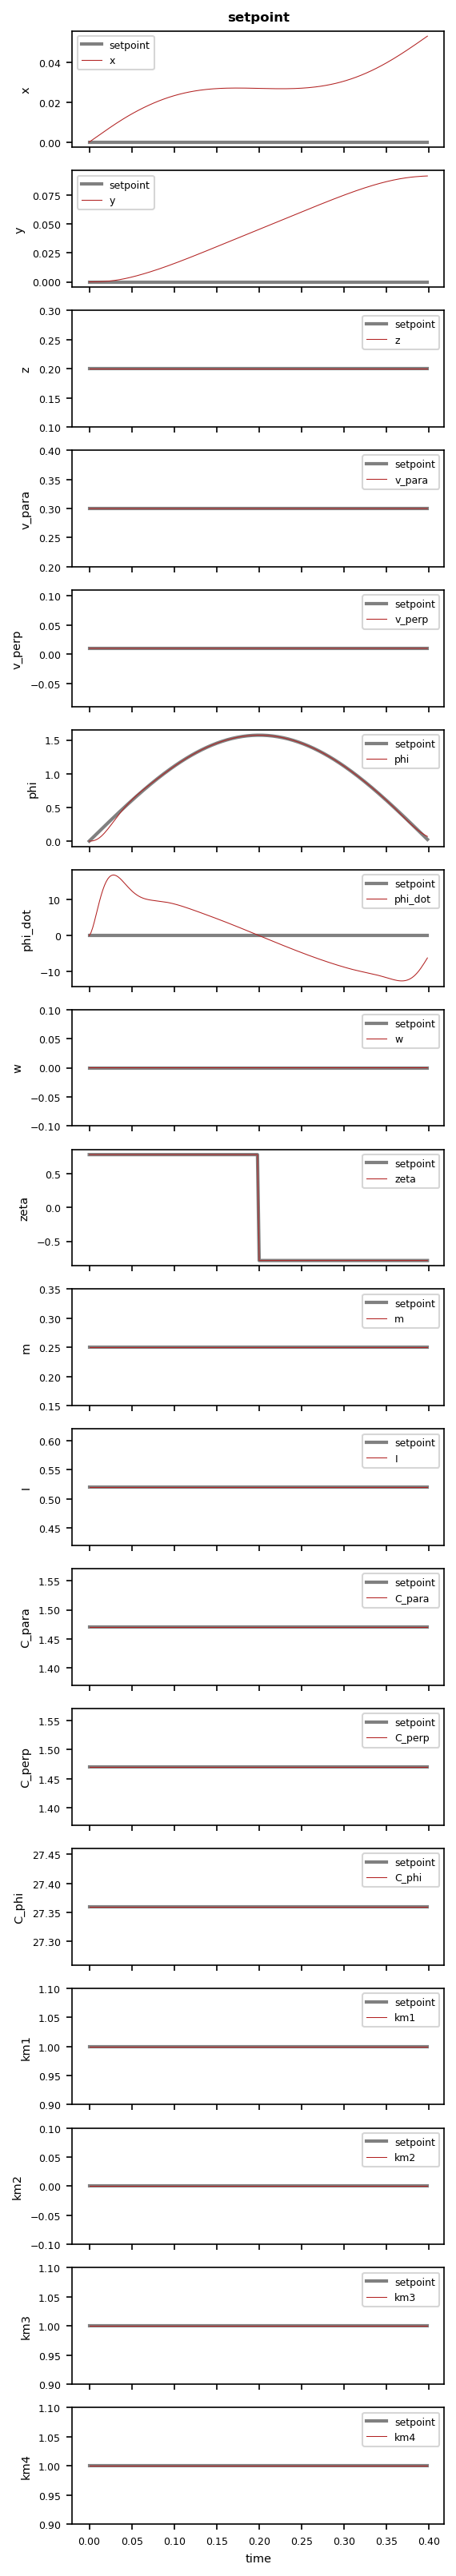

In [11]:
simulator.plot(name='setpoint')

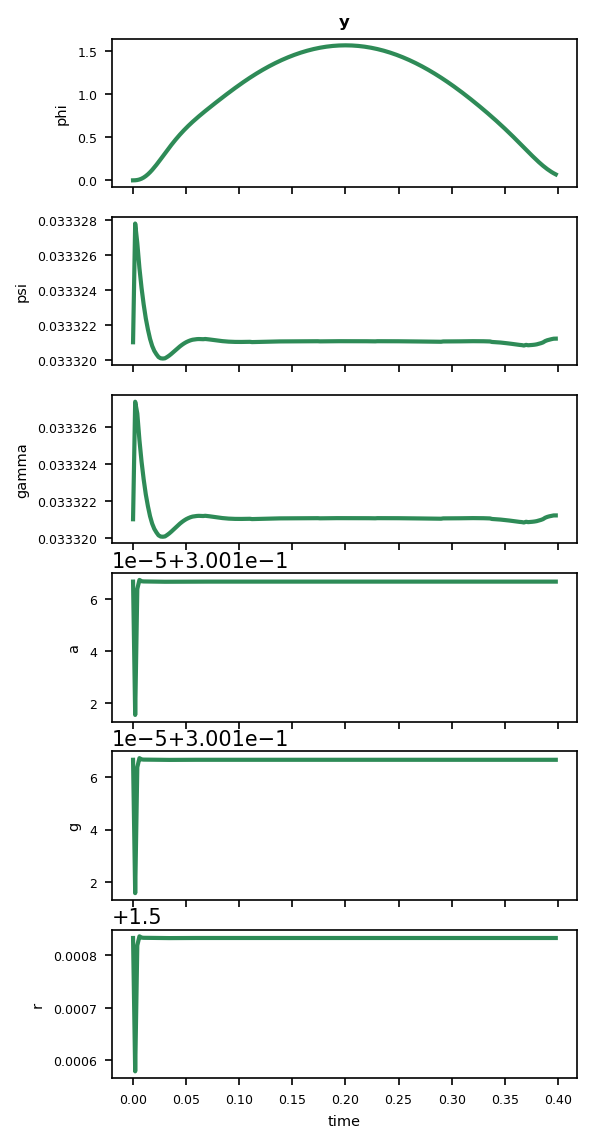

In [12]:
simulator.plot(name='y')

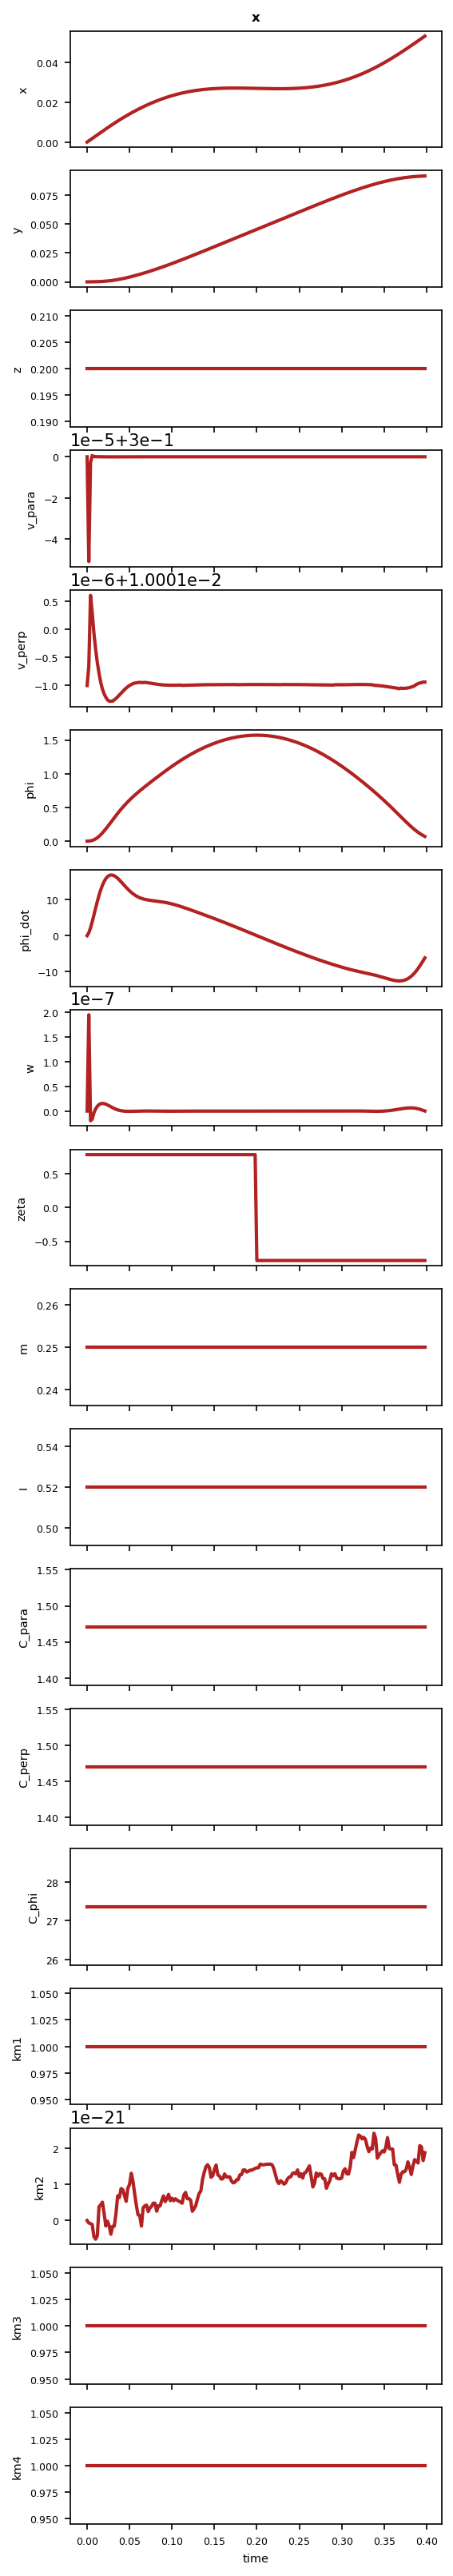

In [13]:
simulator.plot('x')

## Simulate in open loop using the computed controls

In [14]:
t_sim2, x_sim2, u_sim2, y_sim2 = simulator.simulate(x0={'w':0.45}, mpc=False, u=u_sim, return_full_output=True)

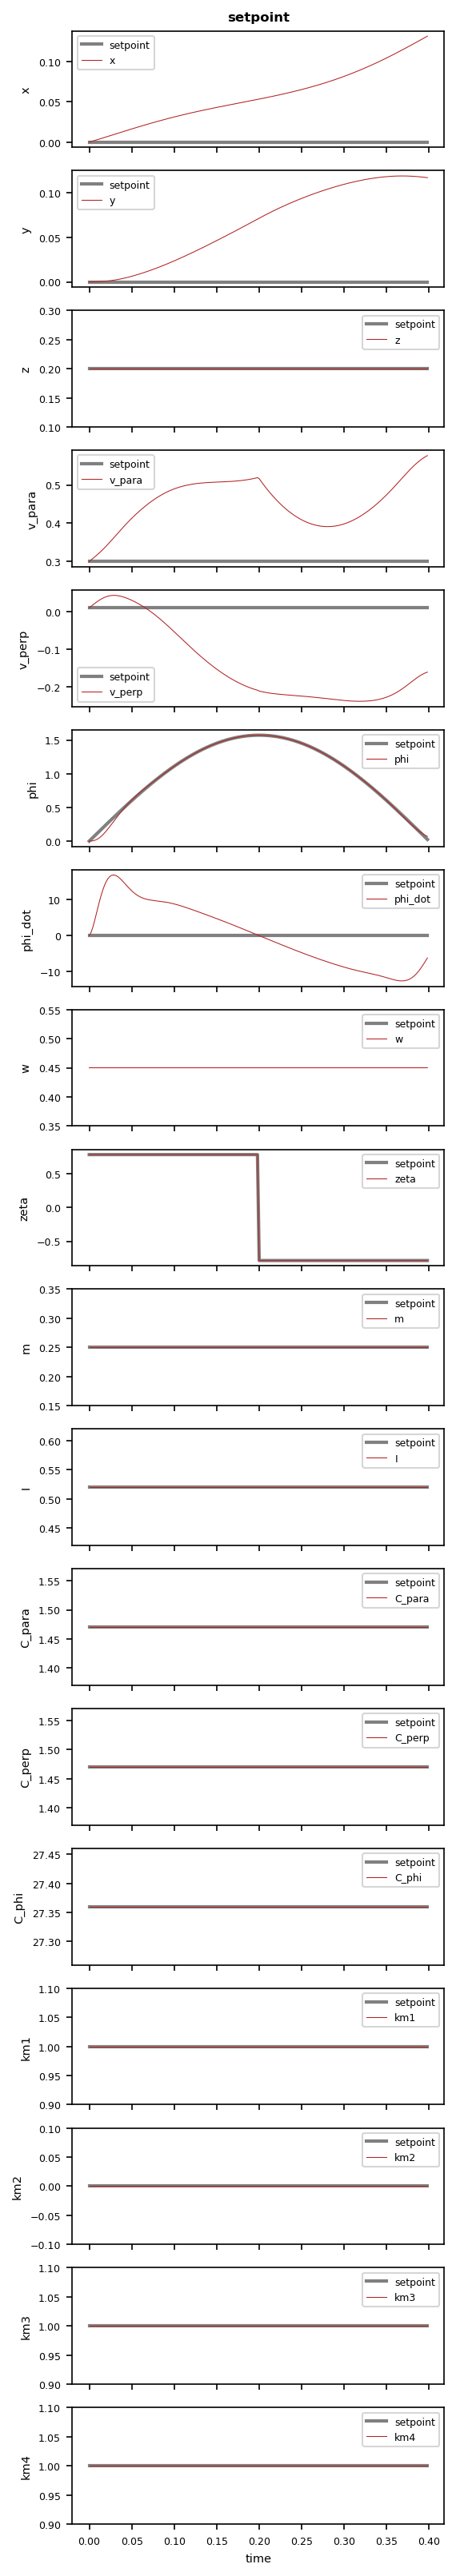

In [15]:
simulator.plot(name='setpoint')

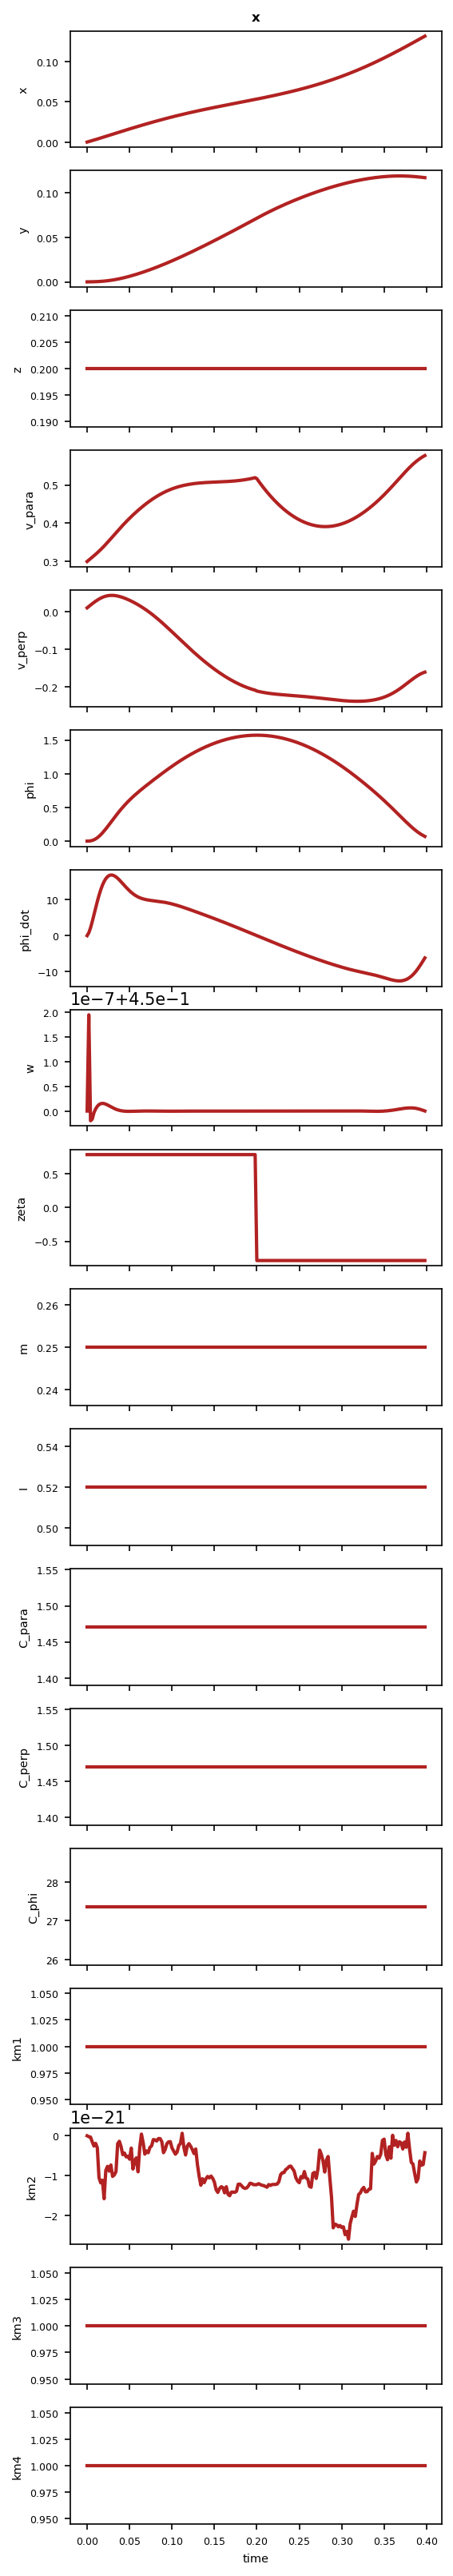

In [16]:
simulator.plot(name='x')

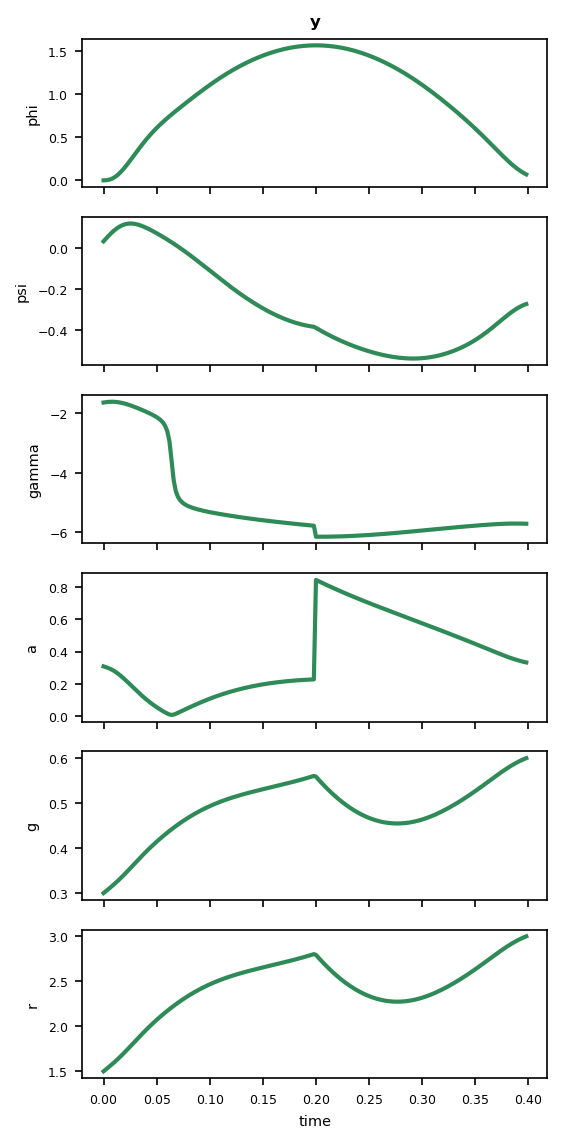

In [17]:
simulator.plot(name='y')

## Christina's loop is below

In [5]:
from keras.models import load_model
from heading_predictor_functions import augment_with_time_delay_embedding, predict_heading_from_fly_trajectory

## Heading Predictor setup.
predictor_input_names = [
    'groundspeed',
    'groundspeed_angle',
    'airspeed',
    'airspeed_angle',
    'thrust',
    'thrust_angle',
]

predictor_output_names = ['heading_angle_x', 'heading_angle_y']

time_window = 4

time_augmentation_kwargs = {
    "time_window": time_window,
    "input_names": predictor_input_names,
    "output_names": predictor_output_names,
    "direction": "backward"
}

headingPredictor=load_model('model_CEM_all-angle-rotate.keras')

C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [7]:
# CEM trajectory parameter values for complex trajectories

# make up a trajectory
fs = 500   # 500 for Mayetal2025
dt = 1 / fs
T = 0.1
tsim = np.arange(0.0, T + 0.9*dt, dt)

v_para_0 = [0.2]
v_para_dot_0 = 50.0 #0.5
v_perp_0 = 0.0
v_perp_dot_0 = 0.0

#initphi = np.array([0.0,np.pi/2,np.pi,3*np.pi/2])
#initphi = initphi-0.02
initphi = [-0.02]
phi_0 = [0.0,np.pi/3,-np.pi/4,-np.pi/4,-3*np.pi/4] #complex-traj01
#phi_0 = [0.0,-np.pi/4,0.0,0.0,-np.pi/4] #complex-traj02

w_0 = [0.45]

zeta_0 = [-np.pi/4,-np.pi/4,-np.pi/4,-3*np.pi/4,-3*np.pi/4] #complex-traj01
#zeta_0 = [np.pi,np.pi,np.pi,np.pi/3,np.pi/3] #complex-traj02

deltaPhi = [np.pi/3,-(np.pi/3+np.pi/4),0.0,-np.pi/2,3*np.pi/4] #complex-traj01 
#deltaPhi = [-np.pi/4,np.pi/4,0.0,-np.pi/4,-2*np.pi/3+np.pi/4] #complex-traj02 

elev = [0.3]

1
2
0.0
3
4
one
24
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
initphi: -0.02
1 out of 1


C:\Users\mayc06\AppData\Local\Temp\ipykernel_23176\2350321177.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)


elapsed time: 265.66882061958313


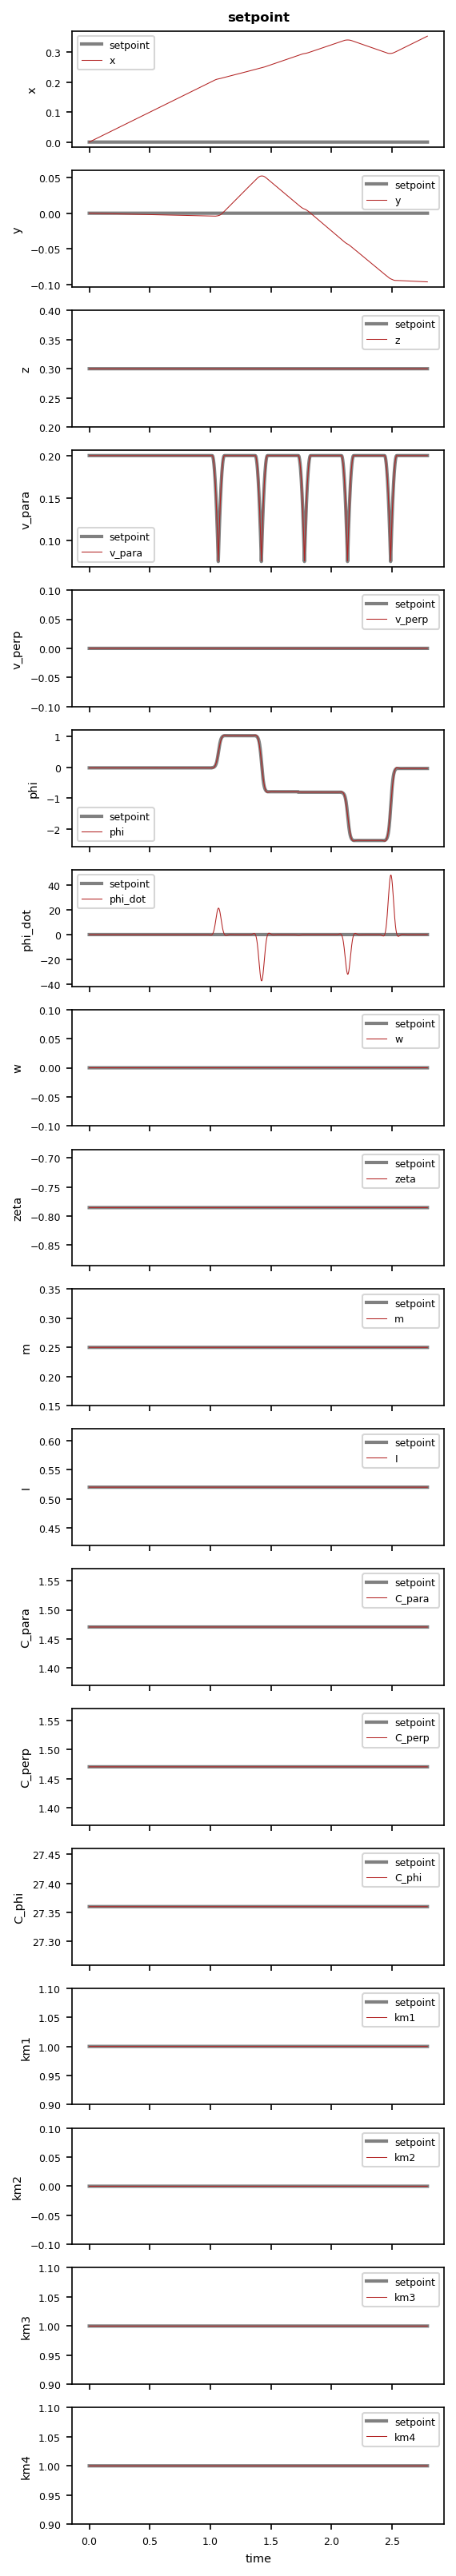

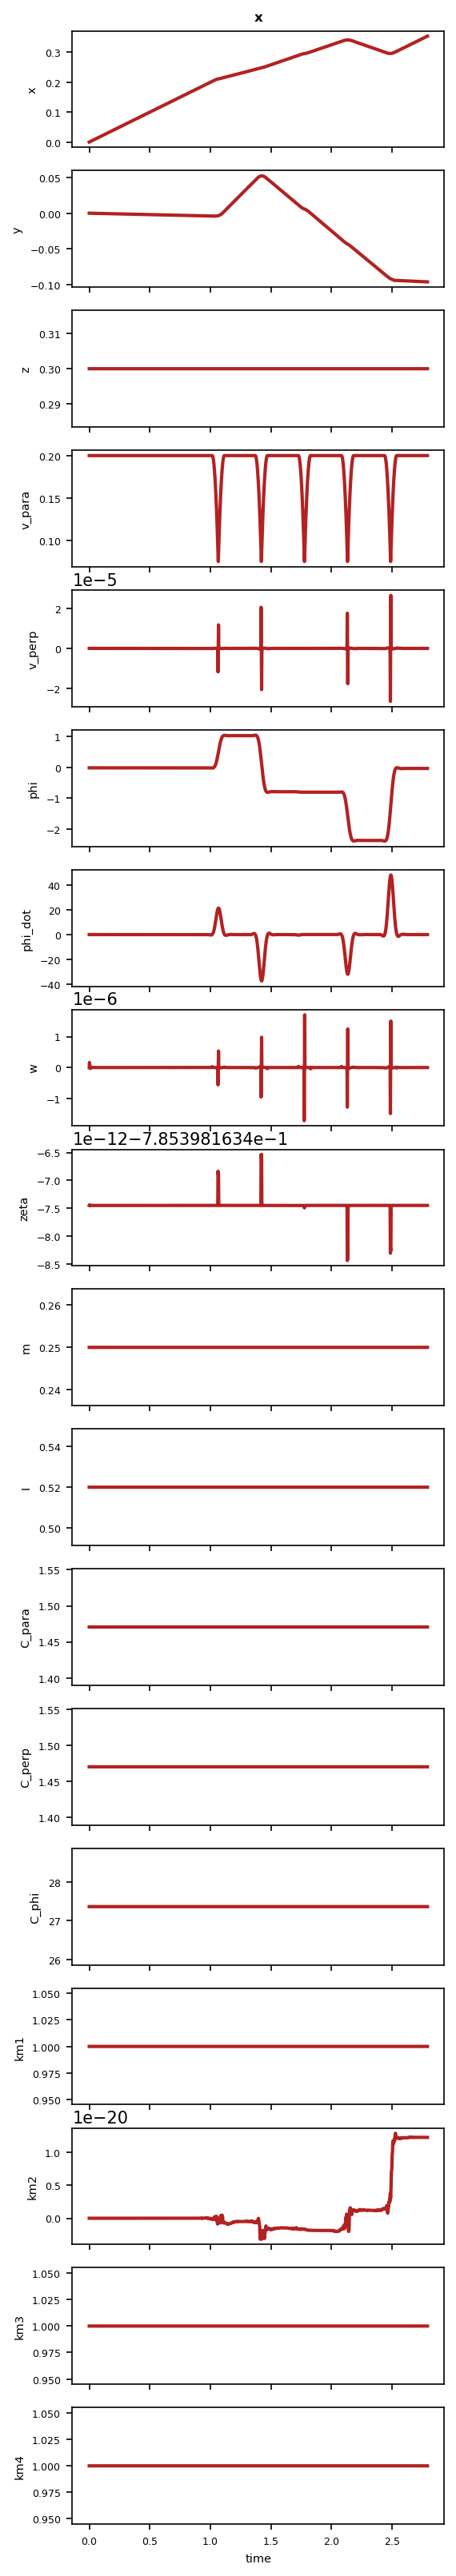

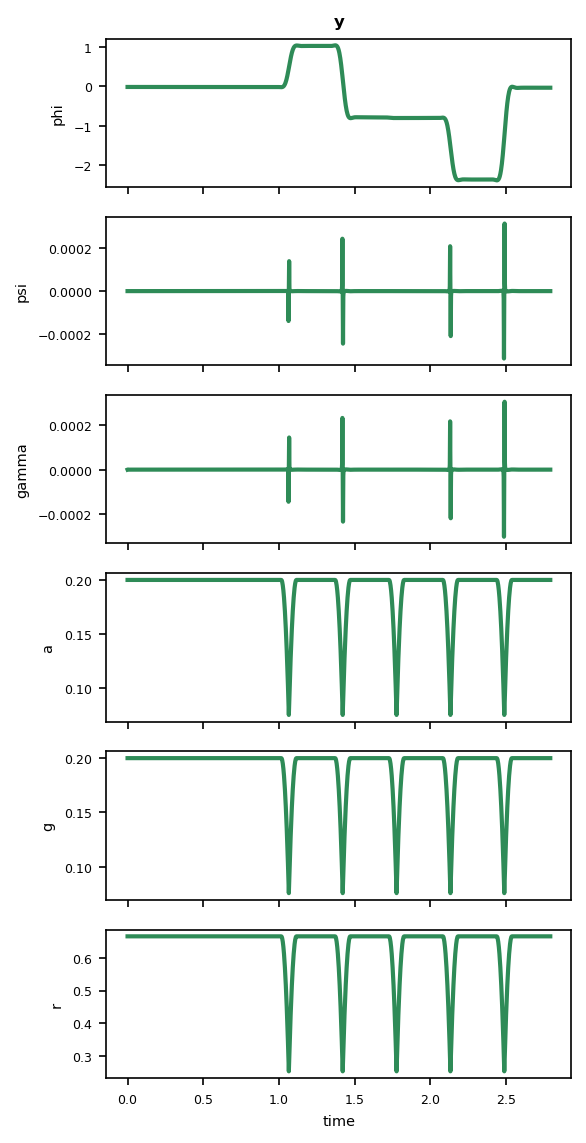

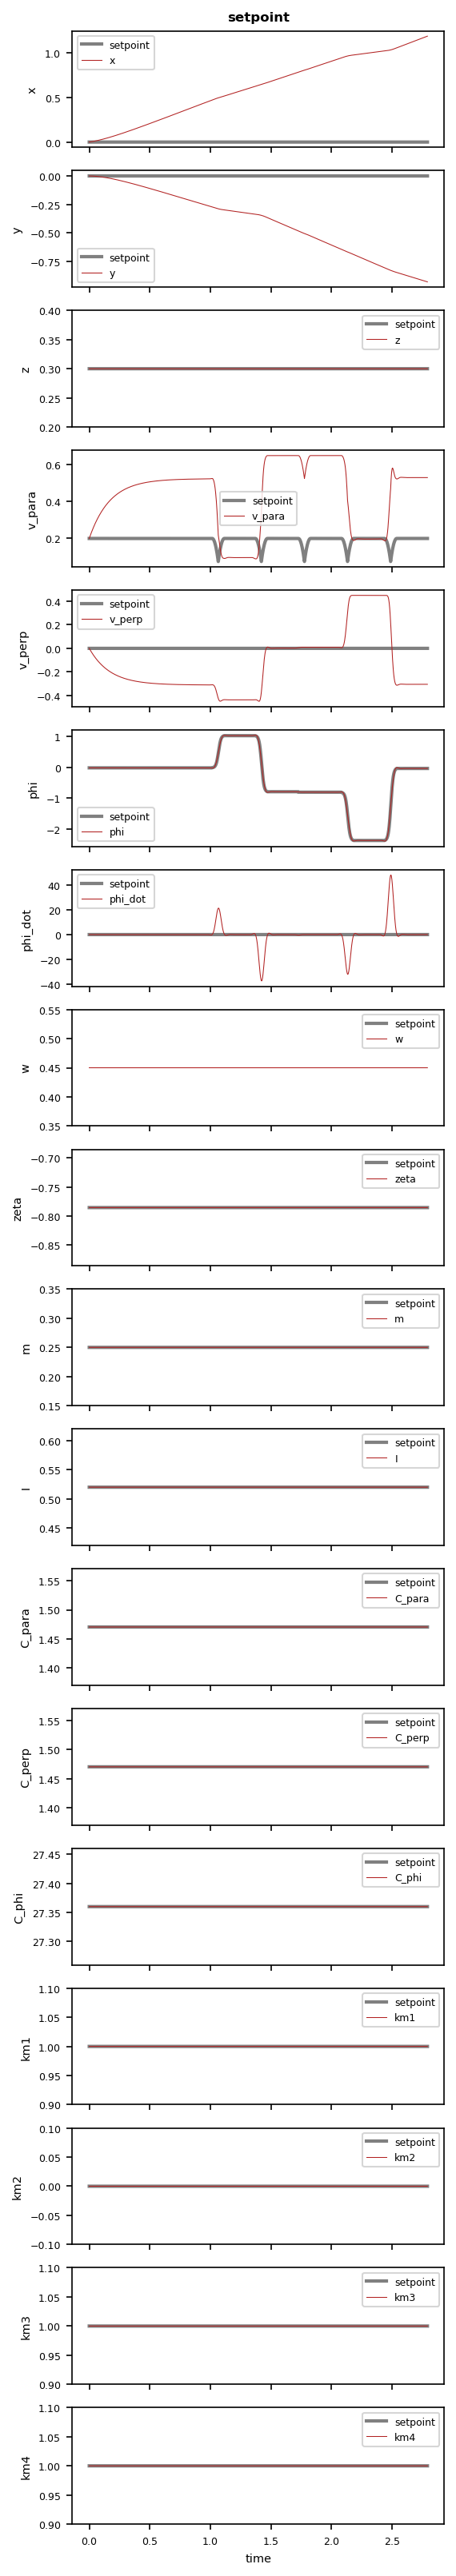

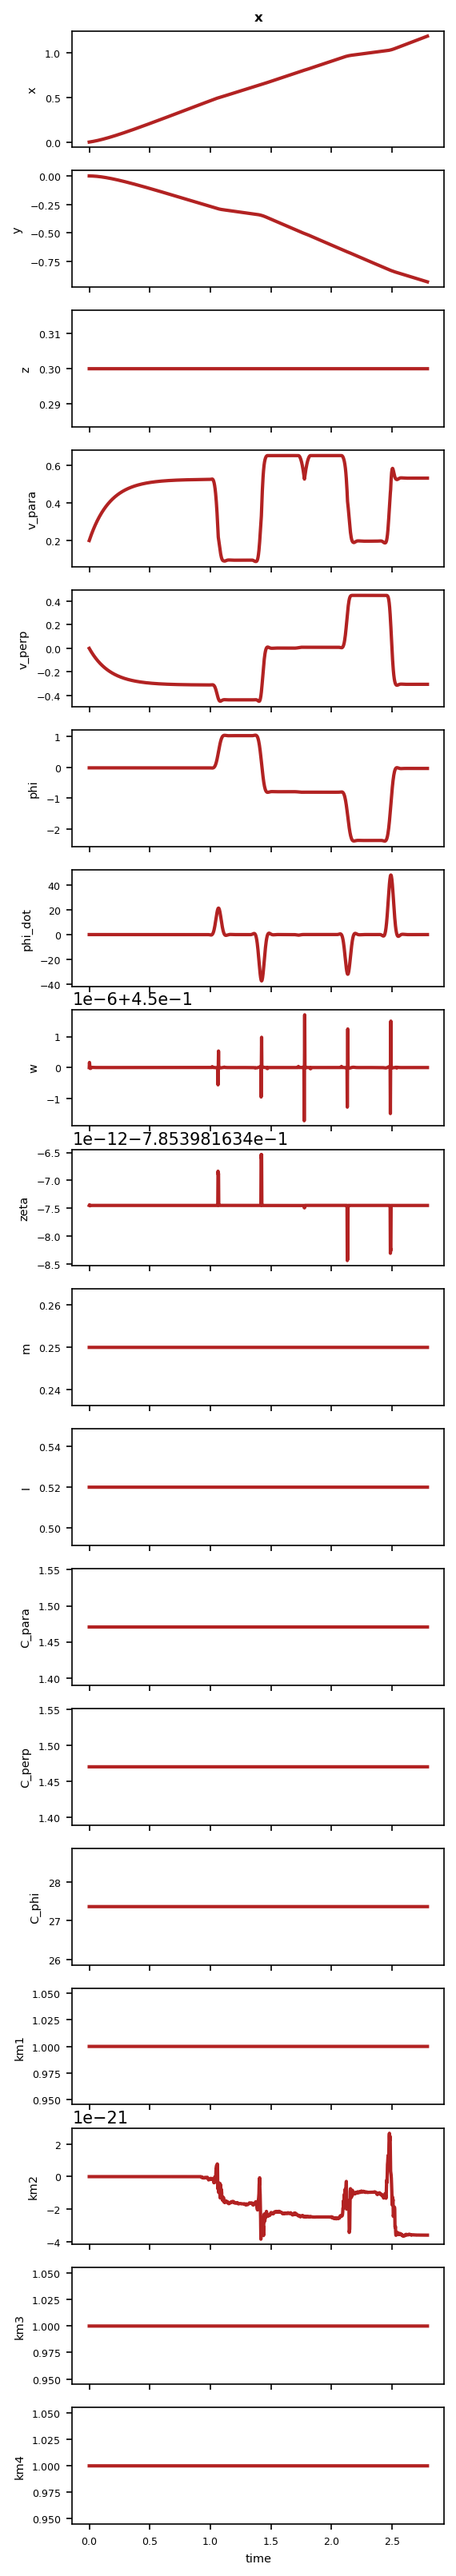

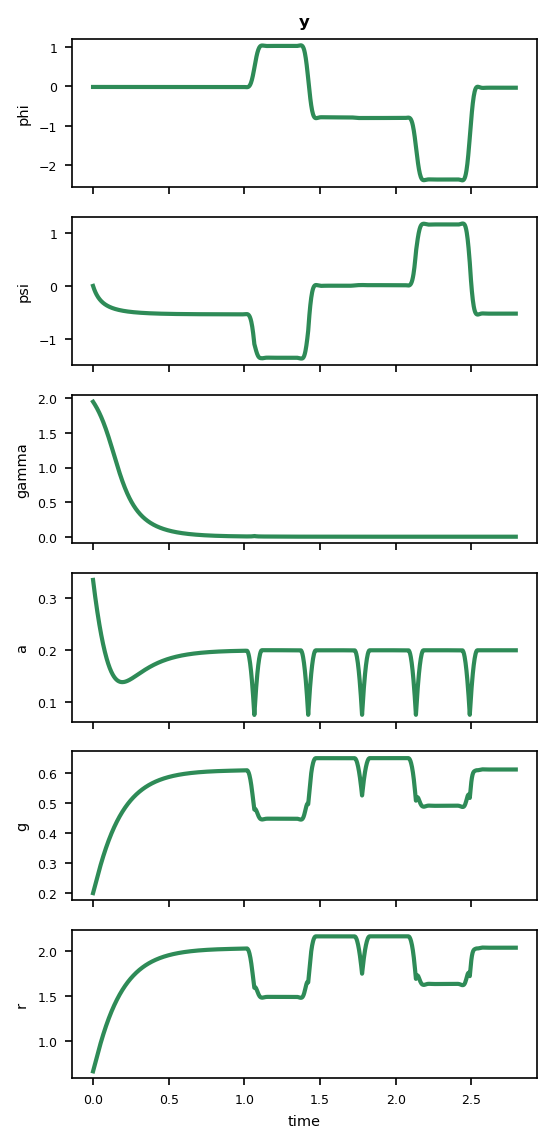

In [13]:
stimulus = pd.DataFrame()
PFNdf = pd.DataFrame()

stimfilename = 'complex-traj01_test03-hor-50_crosscheckedwithBen_withheadingpredictor_stims' #multiPhi0_crosscheckedwithBen
stimfilename = stimfilename+'.csv'
stimfile = open(stimfilename, 'a')

PFNfilename = 'ANN-PFNinputs_complex-traj01_test03-hor-50_crosscheckedwithBen_withheadingpredictor'
PFNfilename = PFNfilename+'.csv'
PFNfile = open(PFNfilename, 'a')

count = 0
n_traj = len(initphi)
for base in initphi:
    
    st = time.time()
    simulator = Simulator(f, h, dt=dt, 
                          state_names=state_names, 
                          input_names=input_names, 
                          measurement_names=measurement_names,
                          mpc_horizon=50
                         )
    
    # Straight-trajectory baseline for first 2.5 s
    space = 1*floor(len(tsim)*2.5)
    zeta = zeta_0[0]*np.ones((4*space,))
    w = w_0[0]*np.ones((4*space,))
    v_perp = v_perp_0*np.ones((4*space,)) #+ v_perp_dot_0*tsim
    v_para = v_para_0*np.ones((4*space,))
    phi = (phi_0[0]+base)*np.ones((4*space,))
    alt = elev*np.ones((4*space,))
    
    zeta = np.append(zeta,zeta_0[0]*np.ones_like(tsim))
    w = np.append(w,w_0[0]*np.ones_like(tsim))
    v_perp = np.append(v_perp,v_perp_0*np.ones_like(tsim) + v_perp_dot_0*tsim)
    vpara_start = v_para_0*np.ones_like(tsim) #+ v_para_dot_0*tsim
    accel = v_para_dot_0*np.square(tsim[0:ceil(len(tsim)/2)]) #v_para_dot_0*np.square(...)
    v_para = np.append(v_para,(vpara_start - np.append(accel,np.flip(accel[:-1]))))
    phi_start = (phi_0[0]+base)*np.ones_like(tsim)
    angaccel = (deltaPhi[0])/(1+np.exp(-100*(tsim-0.052)))       # orig = fast
    #angaccel = (deltaPhi[0])/(1+np.exp(-20*(tsim-0.52)))        # for imaging stims
    phi = np.append(phi,phi_start + angaccel)
    alt = np.append(alt,elev*np.ones_like(tsim))
    
    zeta = np.append(zeta,zeta[-1]*np.ones((space,)))
    w = np.append(w,w[-1]*np.ones((space,)))
    v_perp = np.append(v_perp,v_perp[-1]*np.ones((space,))) #+ v_perp_dot_0*tsim
    v_para = np.append(v_para,v_para[-1]*np.ones((space,)))
    phi = np.append(phi,phi[-1]*np.ones((space,)))
    alt = np.append(alt,alt[-1]*np.ones((space,)))
    
    for i in range(1,5):
        print(i)
        zeta = np.append(zeta,(zeta_0[i])*np.ones_like(tsim)) # +base
        if i==2:
            print(deltaPhi[i])
            zeta[-25:] = (zeta_0[i+1])#+base)            # change wind direction halfway along straightaway
        w = np.append(w,w_0*np.ones_like(tsim))
        v_perp = np.append(v_perp,v_perp_0*np.ones_like(tsim) + v_perp_dot_0*tsim)
        
        vpara_start = v_para_0*np.ones_like(tsim)
        accel = v_para_dot_0*np.square(tsim[0:ceil(len(tsim)/2)]) #v_para_dot_0*np.square(...)
        v_para = np.append(v_para,vpara_start - np.append(accel,np.flip(accel[:-1])))
        
        phi_start = (phi_0[i]+base)*np.ones_like(tsim)
        angaccel = (deltaPhi[i])/(1+np.exp(-100*(tsim-0.052)))       # orig = fast
        #angaccel = (deltaPhi[i])/(1+np.exp(-20*(tsim-0.52)))        # for imaging stims
        heading = phi_start + angaccel
        phi = np.append(phi,heading)
        alt = np.append(alt,elev*np.ones_like(tsim))
        
        # Straight-trajectory baseline for last 2.5 s
        #post = 5*floor(len(tsim)*2.5)
        zeta = np.append(zeta,zeta[-1]*np.ones((space,)))
        w = np.append(w,w[-1]*np.ones((space,)))
        v_perp = np.append(v_perp,v_perp[-1]*np.ones((space,))) #+ v_perp_dot_0*tsim
        v_para = np.append(v_para,v_para[-1]*np.ones((space,)))
        phi = np.append(phi,phi[-1]*np.ones((space,)))
        alt = np.append(alt,alt[-1]*np.ones((space,)))
    
    setpoint_CEM = {'x': 0.0 * np.ones_like(alt),
                    'y': 0.0 * np.ones_like(alt),
                    'z': alt,
                    'v_para': v_para,
                    'v_perp': v_perp,
                    'phi': phi,
                    'phi_dot': 0.0*np.ones_like(alt),
                    'w': 0.0*np.ones_like(alt),         ###
                    #'w': w_0[0]*np.ones_like(alt),
                    #'zeta': 0.0*np.ones_like(alt),
                    #'zeta': zeta,                       ###
                    'zeta': zeta[0]*np.ones_like(alt),
                    'm': m * np.ones_like(alt),
                    'I': I * np.ones_like(alt),
                    'C_para': C_para * np.ones_like(alt),
                    'C_perp': C_perp * np.ones_like(alt),
                    'C_phi': C_phi * np.ones_like(alt),
                    'km1': 1.0 * np.ones_like(alt),
                    'km2': 0.0 * np.ones_like(alt),
                    'km3': 1.0 * np.ones_like(alt),
                    'km4': 1.0 * np.ones_like(alt),
                   }

    # Update the simulator set-point
    simulator.update_dict(setpoint_CEM, name='setpoint')

    # Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
    cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 +
            (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
            (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2 +
            (simulator.model.x['w'] - simulator.model.tvp['w_set']) ** 2 + 
            (simulator.model.x['zeta'] - simulator.model.tvp['zeta_set']) ** 2
           )

    # Set cost function
    simulator.mpc.set_objective(mterm=cost, lterm=cost)

    # Set input penalty: make this small for accurate state following
    simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6, u_w=0.0, u_zeta=0.0)

    print('one')
    t_sim1, x_sim1, u_sim, y_sim1 = simulator.simulate(x0=None, mpc=True, return_full_output=True)
    
    simulator.plot('setpoint')
    simulator.plot('x')
    simulator.plot('y')
    
    #setpoint_CEM['zeta'] = zeta
    #simulator.update_dict(setpoint_CEM, name='setpoint')
    
    t_sim, x_sim, u_sim2, y_sim = simulator.simulate(x0={'w':w_0[0]}, mpc=False, u=u_sim, return_full_output=True)
    
    simulator.plot('setpoint')
    simulator.plot('x')
    simulator.plot('y')

    trajec = pd.DataFrame()
    trajec['timestamp'] = t_sim
    trajec['groundspeed'] = y_sim['g']
    trajec['groundspeed_angle'] = y_sim['psi']+y_sim['phi']
    trajec['thrust'] = np.sqrt(u_sim['u_para']**2 + u_sim['u_perp']**2)
    trajec['thrust_angle'] = np.arctan2(u_sim['u_perp'],u_sim['u_para'])
    trajec['airspeed'] = y_sim['a']
    trajec['airspeed_angle'] = y_sim['gamma']+y_sim['phi']
    trajec['position_x'] = x_sim['x']
    trajec['position_y'] = x_sim['y']
    trajec['heading_angle_x'] = np.cos(y_sim['phi'])
    trajec['heading_angle_y'] = np.sin(y_sim['phi'])

    ## To downsample CEM data
    trajec = trajec.loc[np.arange(0,len(t_sim1),int(0.01/0.002))]
    trajec.reset_index(drop=True,inplace=True)

    heading_angle_predicted = predict_heading_from_fly_trajectory(trajec, 
                                                                  24,
                                                                  augment_with_time_delay_embedding, 
                                                                  headingPredictor, smooth=True,
                                                                  **time_augmentation_kwargs)

    head_pred_unwrap = utils.unwrap_angle(heading_angle_predicted)
    #print(len(head_pred_unwrap),len(t_sim1))

    
    stimulus['time'] = t_sim1
    stimulus['obj_id'] = count
    
    ## If used heading predictor model:
    stimulus['heading'] = np.nan
    stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)
    stimulus['heading'].interpolate(method='cubic',inplace=True,limit=len(t_sim1), limit_direction='both')
    
    ## Without heading predictor model:
    #stimulus['heading'] = np.round(y_sim['phi'],6)
    
    stimulus['course_dir'] = np.round(y_sim['phi'],6)#+y_sim['psi'],6)
    stimulus['airspeed'] = np.round(y_sim['a'],6)
    stimulus['gamma'] = np.round(y_sim['gamma'] + y_sim['phi'],6) - stimulus['heading']
    stimulus['gspd'] = np.round(y_sim['r'],6)
    stimulus['psi'] = np.round(y_sim['psi'] + y_sim['phi'],6) - stimulus['heading']
    #stimulus['psi'] = stimulus['course_dir'] - stimulus['heading']
    stimulus['zeta'] = np.round(x_sim['zeta'],6)
    stimulus['wspd'] = np.round(x_sim['w'],6)
    stimulus['altitude'] = np.round(x_sim['z'],6)
    stimulus['fspd'] = np.round(y_sim['g'],6)
    stimulus['thrust'] = np.sqrt(u_sim['u_para']**2 + u_sim['u_perp']**2)
    stimulus['thrust_angle'] = np.arctan2(u_sim['u_perp'],u_sim['u_para'])
    stimulus['torque'] = u_sim['u_phi']
    stimulus['xpos'] = np.round(x_sim['x'],6)
    stimulus['ypos'] = np.round(x_sim['y'],6)
    stimulus['vpara_input'] = v_para
    stimulus['vperp_input'] = v_perp
    stimulus['phi_input'] = phi
    stimulus['sim1_course_dir'] = np.round(y_sim1['phi'],6)
    stimulus['sim1_xpos'] = np.round(x_sim1['x'],6)
    stimulus['sim1_ypos'] = np.round(x_sim1['y'],6)
    stimulus['sim1_zeta'] = np.round(x_sim1['zeta'],6)
    
    print('initphi:',np.round(base,6))

    if count == 0:
        stimulus.to_csv(stimfile)
    else:
        stimulus.to_csv(stimfile,header=False)
        
    ## Model PFN activity during trajectory
    pfnmodel = PFN()

    p_d = pfnmodel.model_param['PFNd']
    p_v = pfnmodel.model_param['PFNv']
    p_pc = pfnmodel.model_param['PFNpc']
    p_a = pfnmodel.model_param['PFNa']
    AF = [-stimulus['gamma'].copy().iloc[0], 100*stimulus['airspeed'].copy().iloc[0]]
    OF = [-stimulus['psi'].copy().iloc[0], 100*stimulus['gspd'].copy().iloc[0]]   # "gspd" is actually of speed
    bump = [-stimulus['heading'].copy().iloc[0], -stimulus['gamma'].copy().iloc[0], 100*stimulus['airspeed'].copy().iloc[0]]
    initcond = BuildSSInitial(p_d, p_v, p_pc, p_a, AF, OF, bump)

    pfnmodel.run(tsim=np.array(stimulus['time']),
                 phi=-np.array(stimulus['heading']),
                 a=100*np.array(stimulus['airspeed']),
                 gamma=-np.array(stimulus['gamma']),
                 g=100*np.array(stimulus['gspd']),
                 psi=-np.array(stimulus['psi']),
                 initcond=initcond)

    inputs = {}

    neurons = list(pfnmodel.heatmap.keys())
    labels = {'EPG':['EPG_c1','EPG_c2','EPG_c3','EPG_c4','EPG_c5','EPG_c6','EPG_c7','EPG_c8'],
              'PFNdL_pb':['PFNd_c1','PFNd_c2','PFNd_c3','PFNd_c4','PFNd_c5','PFNd_c6','PFNd_c7','PFNd_c8'],
              'PFNdR_pb':['PFNd_c9','PFNd_c10','PFNd_c11','PFNd_c12','PFNd_c13','PFNd_c14','PFNd_c15','PFNd_c16'],
              'PFNvL_pb':['PFNv_c1','PFNv_c2','PFNv_c3','PFNv_c4','PFNv_c5','PFNv_c6','PFNv_c7','PFNv_c8'],
              'PFNvR_pb':['PFNv_c9','PFNv_c10','PFNv_c11','PFNv_c12','PFNv_c13','PFNv_c14','PFNv_c15','PFNv_c16'],
              'PFNpcL_pb':['PFNpc_c1','PFNpc_c2','PFNpc_c3','PFNpc_c4','PFNpc_c5','PFNpc_c6','PFNpc_c7','PFNpc_c8'],
              'PFNpcR_pb':['PFNpc_c9','PFNpc_c10','PFNpc_c11','PFNpc_c12','PFNpc_c13','PFNpc_c14','PFNpc_c15','PFNpc_c16'],
              'PFNaL_pb':['PFNa_c1','PFNa_c2','PFNa_c3','PFNa_c4','PFNa_c5','PFNa_c6','PFNa_c7','PFNa_c8'],
              'PFNaR_pb':['PFNa_c9','PFNa_c10','PFNa_c11','PFNa_c12','PFNa_c13','PFNa_c14','PFNa_c15','PFNa_c16']   
             }
    for celltype in neurons:
        j = 0
        for label in labels[celltype]:
            inputs[label] = pfnmodel.heatmap[celltype][:,j]
            j+=1

    angle_map = np.arange(-np.pi,np.pi,step=np.pi/4)
    n_angles = angle_map.shape[0]
    n_sim = stimulus['time'].shape[0]

    inputs['wind_c1'] = np.empty((n_sim,))
    inputs['wind_c2'] = np.empty((n_sim,))
    inputs['wind_c3'] = np.empty((n_sim,))
    inputs['wind_c4'] = np.empty((n_sim,))
    inputs['wind_c5'] = np.empty((n_sim,))
    inputs['wind_c6'] = np.empty((n_sim,))
    inputs['wind_c7'] = np.empty((n_sim,))
    inputs['wind_c8'] = np.empty((n_sim,))

    for pt in range(n_sim):
        wind = 0.5 + 0.5 * np.cos(angle_map - stimulus['zeta'].iloc[pt] - np.pi)
        inputs['wind_c1'][pt]=wind[0]
        inputs['wind_c2'][pt]=wind[1]
        inputs['wind_c3'][pt]=wind[2]
        inputs['wind_c4'][pt]=wind[3]
        inputs['wind_c5'][pt]=wind[4]
        inputs['wind_c6'][pt]=wind[5]
        inputs['wind_c7'][pt]=wind[6]
        inputs['wind_c8'][pt]=wind[7]

    inputs['obj_id'] = count

    print(str(count+1)+' out of '+str(n_traj))

    PFNdf = pd.DataFrame(inputs)
    if count == 0:
        PFNdf.to_csv(PFNfile)
    elif count!=0:
        PFNdf.to_csv(PFNfile,header=False)

    et = time.time()
    print('elapsed time:', et-st)
    count+=1
        
stimfile.close()
PFNfile.close()

In [27]:
stimfile.close()
PFNfile.close()

In [28]:
len(t_sim1)


1398